In [78]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

### 1. 코로나 영향을 반영할 데이터 생성

In [2]:
data = pd.read_csv('201901-202003.csv')
data = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1, inplace=False)
data = data.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
data.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,건강보조식품 소매업,144,364,1080,148354746,1128
1,201901,강원,골프장 운영업,2947,5745,18489,1229200312,33379
2,201901,강원,과실 및 채소 소매업,3184,7597,23566,1286979106,31050
3,201901,강원,관광 민예품 및 선물용품 소매업,380,761,1059,30656770,1254
4,201901,강원,그외 기타 스포츠시설 운영업,26,65,121,13101500,168


In [6]:
# 19년 2월, 20년 2월 데이터 비교
data19_2 = data[data['REG_YYMM'] == 201902]
data19_2 = data19_2.rename(columns={"AMT":"AMT19_2"}, inplace=False)
data19_2 = data19_2[['CARD_SIDO_NM','STD_CLSS_NM','AMT19_2']]
print(data19_2.shape)

(627, 3)


In [7]:
data20_2 = data[data['REG_YYMM'] == 202002]
data20_2 = data20_2.rename(columns={"AMT":"AMT20_2"}, inplace=False)
data20_2 = data20_2[['CARD_SIDO_NM','STD_CLSS_NM','AMT20_2']]
print(data20_2.shape)

(623, 3)


In [8]:
data_2 = pd.merge(data19_2, data20_2, how='outer')
data_2['AMT_diff_2'] = data_2['AMT19_2'] - data_2['AMT20_2']
data_2.head()

,CARD_SIDO_NM,STD_CLSS_NM,AMT19_2,AMT20_2,AMT_diff_2
0,강원,건강보조식품 소매업,1.467159e+08,76505561.0,70210310.0
1,강원,골프장 운영업,1.152241e+09,968456455.0,183784517.0
2,강원,과실 및 채소 소매업,1.116266e+09,867214360.0,249051523.0
3,강원,관광 민예품 및 선물용품 소매업,2.292115e+07,16375500.0,6545649.0
4,강원,그외 기타 스포츠시설 운영업,7.139500e+06,5065100.0,2074400.0


In [9]:
print('전체 2월 감소량 평균 : ', data_2['AMT_diff_2'].mean())
for i in data_2['CARD_SIDO_NM'].unique():
  print(i, '2월 감소량 평균 : ', data_2[data_2['CARD_SIDO_NM'] == i]['AMT_diff_2'].mean())

전체 2월 감소량 평균 :  429276951.03094465
강원 2월 감소량 평균 :  228965133.7027027
경기 2월 감소량 평균 :  865595292.1081082
경남 2월 감소량 평균 :  153321020.7948718
경북 2월 감소량 평균 :  303551154.5833333
광주 2월 감소량 평균 :  113386779.17142858
대구 2월 감소량 평균 :  523693454.71428573
대전 2월 감소량 평균 :  117554990.21875
부산 2월 감소량 평균 :  846641480.475
서울 2월 감소량 평균 :  1967953506.025641
세종 2월 감소량 평균 :  -41301860.68965517
울산 2월 감소량 평균 :  75197620.2
인천 2월 감소량 평균 :  845509063.2631578
전남 2월 감소량 평균 :  88044942.72972973
전북 2월 감소량 평균 :  291035169.4054054
제주 2월 감소량 평균 :  344670861.0277778
충남 2월 감소량 평균 :  172109859.97297296
충북 2월 감소량 평균 :  89395710.25714286


In [11]:
# 19년 3월, 20년 3월 데이터 비교
data19_3 = data[data['REG_YYMM'] == 201903]
data19_3 = data19_3.rename(columns={"AMT":"AMT19_3"}, inplace=False)
data19_3 = data19_3[['CARD_SIDO_NM','STD_CLSS_NM','AMT19_3']]
print(data19_3.shape)

(630, 3)


In [12]:
data20_3 = data[data['REG_YYMM'] == 202003]
data20_3 = data20_3.rename(columns={"AMT":"AMT20_3"}, inplace=False)
data20_3 = data20_3[['CARD_SIDO_NM','STD_CLSS_NM','AMT20_3']]
print(data20_3.shape)

(609, 3)


In [13]:
data_3 = pd.merge(data19_3, data20_3, how='outer')
data_3['AMT_diff_3'] = data_3['AMT19_3'] - data_3['AMT20_3']
data_3.head()

,CARD_SIDO_NM,STD_CLSS_NM,AMT19_3,AMT20_3,AMT_diff_3
0,강원,건강보조식품 소매업,1.094390e+08,9.605901e+07,13380013.0
1,강원,골프장 운영업,2.760497e+09,2.915798e+09,-155300856.0
2,강원,과실 및 채소 소매업,9.392280e+08,9.948169e+08,-55588993.0
3,강원,관광 민예품 및 선물용품 소매업,2.502319e+07,1.331730e+07,11705890.0
4,강원,그외 기타 스포츠시설 운영업,6.817720e+06,2.075000e+06,4742720.0


In [14]:
print('전체 3월 감소량 평균 : ', data_3['AMT_diff_3'].mean())
for i in data_3['CARD_SIDO_NM'].unique():
  print(i, '3월 감소량 평균 : ', data_3[data_3['CARD_SIDO_NM'] == i]['AMT_diff_3'].mean())

전체 3월 감소량 평균 :  1102627185.6247933
강원 3월 감소량 평균 :  335406159.4722222
경기 3월 감소량 평균 :  2244416496.1578946
경남 3월 감소량 평균 :  703540685.9210526
경북 3월 감소량 평균 :  1053658781.9166666
광주 3월 감소량 평균 :  189284111.78787878
대구 3월 감소량 평균 :  1619799980.7941177
대전 3월 감소량 평균 :  359263569.4848485
부산 3월 감소량 평균 :  2033518264.7435896
서울 3월 감소량 평균 :  5713598741.871795
세종 3월 감소량 평균 :  50142870.14285714
울산 3월 감소량 평균 :  453404601.2647059
인천 3월 감소량 평균 :  1390116527.2368422
전남 3월 감소량 평균 :  101860935.80555555
전북 3월 감소량 평균 :  332121380.4324324
제주 3월 감소량 평균 :  509768242.2222222
충남 3월 감소량 평균 :  503329965.9444444
충북 3월 감소량 평균 :  225785156.05882353


In [18]:
# 19년 4월, 20년 4월 데이터 비교
data19_4 = data[data['REG_YYMM'] == 201904]
data19_4 = data19_4.rename(columns={"AMT":"AMT19_4"}, inplace=False)
data19_4 = data19_4[['CARD_SIDO_NM','STD_CLSS_NM','AMT19_4']]
print(data19_4.shape)

(633, 3)


In [19]:
data2 = pd.read_csv('202004.csv')
data2 = data2.drop(['CARD_CCG_NM','HOM_CCG_NM'], axis=1, inplace=False)
data2 = data2.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
data2.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,202004,강원,건강보조식품 소매업,106,271,782,88823988,862
1,202004,강원,골프장 운영업,2583,7708,25172,4708346820,32298
2,202004,강원,과실 및 채소 소매업,2316,5475,23201,1121028924,33123
3,202004,강원,관광 민예품 및 선물용품 소매업,206,445,582,14360780,702
4,202004,강원,그외 기타 스포츠시설 운영업,2,6,6,227200,14


In [20]:
data20_4 = data2.rename(columns={"AMT":"AMT20_4"}, inplace=False)
data20_4 = data20_4[['CARD_SIDO_NM','STD_CLSS_NM','AMT20_4']]
print(data20_4.shape)

(610, 3)


In [21]:
data_4 = pd.merge(data19_4, data20_4, how='outer')
data_4['AMT_diff_4'] = data_4['AMT19_4'] - data_4['AMT20_4']
data_4.head()

,CARD_SIDO_NM,STD_CLSS_NM,AMT19_4,AMT20_4,AMT_diff_4
0,강원,건강보조식품 소매업,1.065485e+08,8.882399e+07,17724485.0
1,강원,골프장 운영업,3.964893e+09,4.708347e+09,-743453540.0
2,강원,과실 및 채소 소매업,8.276834e+08,1.121029e+09,-293345564.0
3,강원,관광 민예품 및 선물용품 소매업,1.790561e+07,1.436078e+07,3544830.0
4,강원,그외 기타 스포츠시설 운영업,5.904100e+06,2.272000e+05,5676900.0


In [22]:
print('전체 4월 감소량 평균 : ', data_4['AMT_diff_4'].mean())
for i in data_4['CARD_SIDO_NM'].unique():
  print(i, '4월 감소량 평균 : ', data_4[data_4['CARD_SIDO_NM'] == i]['AMT_diff_4'].mean())

전체 4월 감소량 평균 :  761988762.0247934
강원 4월 감소량 평균 :  99193455.45945945
경기 4월 감소량 평균 :  1226198212.1578948
경남 4월 감소량 평균 :  290989505.53846157
경북 4월 감소량 평균 :  589516013.5428572
광주 4월 감소량 평균 :  -12027591.666666666
대구 4월 감소량 평균 :  1041807417.5
대전 4월 감소량 평균 :  183679698.40625
부산 4월 감소량 평균 :  1485736670.7297297
서울 4월 감소량 평균 :  4762102627.564102
세종 4월 감소량 평균 :  24690156.48148148
울산 4월 감소량 평균 :  218756778.77142859
인천 4월 감소량 평균 :  1281928855.368421
전남 4월 감소량 평균 :  54592985.80555555
전북 4월 감소량 평균 :  233303371.1081081
제주 4월 감소량 평균 :  451618747.3783784
충남 4월 감소량 평균 :  261220850.0
충북 4월 감소량 평균 :  102019305.58333333


In [23]:
# 전년 대비 증감 퍼센트 컬럼 추가
data_2['AMT_per_2'] = data_2['AMT20_2']/data_2['AMT19_2']
data_3['AMT_per_3'] = data_3['AMT20_3']/data_3['AMT19_3']
data_4['AMT_per_4'] = data_4['AMT20_4']/data_4['AMT19_4']

m_data = pd.merge(data_2, data_3, how='outer')
total_data = pd.merge(m_data, data_4, how='outer')
total_data = total_data[['CARD_SIDO_NM','STD_CLSS_NM','AMT_per_2','AMT_per_3','AMT_per_4']]
total_data['AMT_per_mean'] = (total_data['AMT_per_2'] + total_data['AMT_per_3'] + total_data['AMT_per_4'])/3
total_data.head()

,CARD_SIDO_NM,STD_CLSS_NM,AMT_per_2,AMT_per_3,AMT_per_4,AMT_per_mean
0,강원,건강보조식품 소매업,0.521454,0.877740,0.833649,0.744281
1,강원,골프장 운영업,0.840498,1.056258,1.187509,1.028089
2,강원,과실 및 채소 소매업,0.776889,1.059186,1.354418,1.063497
3,강원,관광 민예품 및 선물용품 소매업,0.714428,0.532198,0.802027,0.682884
4,강원,그외 기타 스포츠시설 운영업,0.709447,0.304354,0.038482,0.350761


In [25]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 0 to 641
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CARD_SIDO_NM  642 non-null    object 
 1   STD_CLSS_NM   642 non-null    object 
 2   AMT_per_2     614 non-null    float64
 3   AMT_per_3     605 non-null    float64
 4   AMT_per_4     605 non-null    float64
 5   AMT_per_mean  596 non-null    float64
dtypes: float64(4), object(2)
memory usage: 35.1+ KB


In [26]:
total_data['AMT_per_mean'] = total_data['AMT_per_mean'].fillna(1)
total_data.to_csv('AMT_per_mean.csv', encoding='utf-8-sig')

### 2. 데이터 전처리

In [27]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [28]:
# 날짜 처리
data = pd.read_csv('201901-202003.csv')
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1


In [29]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24697792 entries, 0 to 24697791
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   CARD_SIDO_NM  object
 1   CARD_CCG_NM   object
 2   STD_CLSS_NM   object
 3   HOM_SIDO_NM   object
 4   HOM_CCG_NM    object
 5   AGE           object
 6   SEX_CTGO_CD   int64 
 7   FLC           int64 
 8   CSTMR_CNT     int64 
 9   AMT           int64 
 10  CNT           int64 
 11  year          int64 
 12  month         int64 
dtypes: int64(7), object(6)
memory usage: 2.4+ GB
None
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
year                 0
month                0
dtype: int64


In [30]:
# 데이터 정제
df = data.copy()
df = df.drop(['CARD_CCG_NM','HOM_CCG_NM','CSTMR_CNT','CNT'], axis=1)

columns = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM',
           'AGE','SEX_CTGO_CD','FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,AMT
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,311200
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,605000
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,139000
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,27500
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,395500


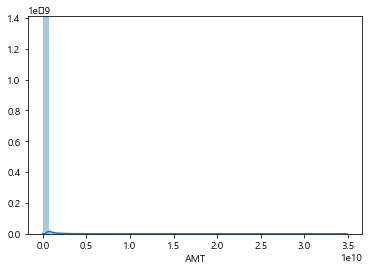

In [36]:
# 타깃 값이 정규 분포인지 확인
sns.distplot(df['AMT'])

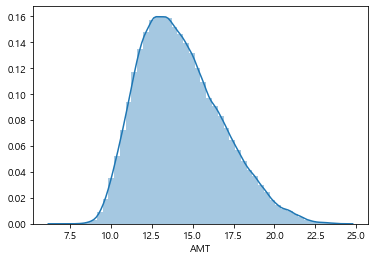

In [38]:
# 로그 변환 후 학습, 예측 시 다시 결괏값을 expm1()으로 환원
org_AMT = df['AMT']
df['AMT'] = np.log1p(df['AMT'])
sns.distplot(df['AMT'])

In [54]:
# 문자열 피처 원핫인코딩
print('get_dummies() 수행 전 데이터 Shape: ', df.shape)
df_ohe = pd.get_dummies(df)
print('get_dummies() 수행 후 데이터 Shape: ', df_ohe.shape)

# non-ascii characters 오류 방지
df_ohe = df_ohe.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

get_dummies() 수행 전 데이터 Shape:  (1057394, 9)
get_dummies() 수행 후 데이터 Shape:  (1057394, 87)


In [55]:
df_ohe.head()

,SEX_CTGO_CD,FLC,year,month,AMT,CARD_SIDO_NM_,CARD_SIDO_NM_,CARD_SIDO_NM_,CARD_SIDO_NM_,CARD_SIDO_NM_,...,HOM_SIDO_NM_,HOM_SIDO_NM_,HOM_SIDO_NM_,AGE_10s,AGE_20s,AGE_30s,AGE_40s,AGE_50s,AGE_60s,AGE_70s
0,1,1,2019,1,12.648194,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,2019,2,13.312985,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1,2019,6,11.842236,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,1,2019,8,10.221978,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,2019,9,12.887909,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### 3. LGBM 모델 학습

In [62]:
# feature, target 설정
train_num = df_ohe.sample(frac=1, random_state=0)
x = train_num.drop(['AMT'], axis=1)
y = train_num['AMT']
k = int(len(x)*0.9)

x_train = x[:k]
y_train = y[:k]
x_val = x[k:]
y_val = y[k:]

In [63]:
train_ds = lgb.Dataset(x_train, label=y_train)
val_ds = lgb.Dataset(x_val, label=y_val)

params = {
    'learning_rate' : 0.05,
    'boosting_type' : 'gbdt',
    'objective' : 'tweedie',
    'tweedie_variance_power' : 1.1,
    'metric' : 'rmse',
    'sub_row' : 0.75,
    'lambda_l2' : 0.1
}

model = lgb.train(params,
                  train_ds,
                  1000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                  )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.98853
[200]	valid_0's rmse: 1.78534
[300]	valid_0's rmse: 1.64852
[400]	valid_0's rmse: 1.51748
[500]	valid_0's rmse: 1.41861
[600]	valid_0's rmse: 1.34521
[700]	valid_0's rmse: 1.28064
[800]	valid_0's rmse: 1.22905
[900]	valid_0's rmse: 1.18429
[1000]	valid_0's rmse: 1.15199
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.15199


### 4. 예측 템플릿에 모델 적용

In [64]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = data['CARD_SIDO_NM'].unique()
STD_CLSS_NMs = data['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = data['HOM_SIDO_NM'].unique()
AGEs = data['AGE'].unique()
SEX_CTGO_CDs = data['SEX_CTGO_CD'].unique()
FLCs = data['FLC'].unique()
years = [2020]
months = [4, 7]

In [65]:
x = df.drop(['AMT'], axis=1, inplace=False)
temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM,
                                             HOM_SIDO_NM, AGE, SEX_CTGO_CD,
                                             FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=x.columns)
temp

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month
0,강원,건강보조식품 소매업,강원,20s,1,1,2020,4
1,강원,건강보조식품 소매업,강원,20s,1,1,2020,7
2,강원,건강보조식품 소매업,강원,20s,1,2,2020,4
3,강원,건강보조식품 소매업,강원,20s,1,2,2020,7
4,강원,건강보조식품 소매업,강원,20s,1,3,2020,4
...,...,...,...,...,...,...,...,...
1658855,충북,정기 항공 운송업,제주,10s,2,3,2020,7
1658856,충북,정기 항공 운송업,제주,10s,2,4,2020,4
1658857,충북,정기 항공 운송업,제주,10s,2,4,2020,7
1658858,충북,정기 항공 운송업,제주,10s,2,5,2020,4


In [66]:
# 원핫인코딩은 object 타입에만 적용이 되므로,
# 인코딩을 적용하면 안 되는 컬럼들을 모두 int 타입으로 변경
temp['SEX_CTGO_CD'] = temp['SEX_CTGO_CD'].map(lambda x : int(x))
temp['FLC'] = temp['FLC'].map(lambda x : int(x))
temp['year'] = temp['year'].map(lambda x : int(x))
temp['month'] = temp['month'].map(lambda x : int(x))

In [67]:
# 문자열 피처 원핫인코딩
print('get_dummies() 수행 전 데이터 Shape: ', temp.shape)
temp_ohe = pd.get_dummies(temp)
print('get_dummies() 수행 후 데이터 Shape: ', temp_ohe.shape)

get_dummies() 수행 전 데이터 Shape:  (1658860, 8)
get_dummies() 수행 후 데이터 Shape:  (1658860, 86)


In [68]:
temp_ohe.head()

,SEX_CTGO_CD,FLC,year,month,CARD_SIDO_NM_강원,CARD_SIDO_NM_경기,CARD_SIDO_NM_경남,CARD_SIDO_NM_경북,CARD_SIDO_NM_광주,CARD_SIDO_NM_대구,...,HOM_SIDO_NM_제주,HOM_SIDO_NM_충남,HOM_SIDO_NM_충북,AGE_10s,AGE_20s,AGE_30s,AGE_40s,AGE_50s,AGE_60s,AGE_70s
0,1,1,2020,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,2020,7,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,2,2020,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,2,2020,7,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,3,2020,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [69]:
# 예측
pred = model.predict(temp_ohe)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

### 5. 제출 파일 생성

In [71]:
# 제출 파일 만들기
submission = pd.read_csv('submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('submission10_LGBM.csv', encoding='utf-8-sig')
submission10 = pd.read_csv('submission10_LGBM.csv')
submission10.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,2.773641e+08
1,1,202004,강원,골프장 운영업,1.667510e+09
2,2,202004,강원,과실 및 채소 소매업,9.066541e+08
3,3,202004,강원,관광 민예품 및 선물용품 소매업,5.129364e+07
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,2.843996e+07


In [74]:
# 코로나 영향 반영
amt_per_mean = pd.read_csv('amt_per_mean.csv')
amt_per_mean = amt_per_mean[['CARD_SIDO_NM','STD_CLSS_NM','AMT_per_mean']]

In [76]:
total_data = pd.merge(submission10, amt_per_mean, how='left')
total_data = total_data.sort_values(by='id')
total_data['AMT_per_mean'] = total_data['AMT_per_mean'].fillna(1)
total_data['AMT'] = total_data['AMT'] * total_data['AMT_per_mean']
total_data = total_data.drop(['AMT_per_mean'], axis=1, inplace=False)
total_data.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,2.064368e+08
1,1,202004,강원,골프장 운영업,1.714348e+09
2,2,202004,강원,과실 및 채소 소매업,9.642243e+08
3,3,202004,강원,관광 민예품 및 선물용품 소매업,3.502762e+07
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,2.843996e+07


In [77]:
total_data.to_csv('submission13_LGBM.csv', encoding='utf-8-sig')